In [1]:
import agentpy as ap

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import IPython
import random as rand

matplotlib.rcParams['animation.embed_limit'] = 2**128

In [2]:
class InfectionModel(ap.Model):
    def setup(self):
        #create agents (Persons)
        nPersons = int(self.p['Population Density'] * (self.p.size**2))
        persons = self.agents = ap.AgentList(self, nPersons)
        
        #create grid (local area)
        self.city = ap.Grid(self, [self.p.size]*2, track_empty=True)
        self.city.add_agents(persons, random=True, empty=True)
        
        #Dynamic variable for all persons
        # Condition {0: Susceptible, 1: recently infected, 2: infected, 3: recovered}
        self.agents.condition = 0
        
        #Set patient(s) zero
        self.agents.random(self.p['Initial Infected']).condition = 1
        
    def update(self):
        pop = 0
        for i in range(0,4):
            pop += len(self.agents.select(self.agents.condition == i))
        self['S'] = len(self.agents.select(self.agents.condition == 0))/pop
        self['I'] = (len(self.agents.select(self.agents.condition == 1)) + len(self.agents.select(self.agents.condition == 2)))/pop
        self['R'] = len(self.agents.select(self.agents.condition == 3))/pop
        self.record('S')
        self.record('I')
        self.record('R')
        
        
    def step(self):
        # select infected population
        infected_Population = self.agents.select(self.agents.condition == 1)
        infected_Population += self.agents.select(self.agents.condition == 2)
        recently_Infected = self.agents.select(self.agents.condition == 1)
        recovered_Population = self.agents.select(self.agents.condition == 3)
        
        # spread infection
        for inf in infected_Population:
            for neighbor in self.city.neighbors(inf):
                if neighbor.condition == 0:
                    if rand.uniform(0,1) < self.p['Infection Probability']:
                        neighbor.condition = 1
                        
        # move recently infected to regular infected
        for inf in recently_Infected:
            inf.condition = 2
        
        # recover infection
        for inf in infected_Population:
            if rand.uniform(0,1) < self.p['Recovery Probability']:
                inf.condition = 3
            
        # Loss of natural immunity
        for rec in recovered_Population:
            if rand.uniform(0,1) < self.p['Resusceptibility Probability']:
                rec.condition = 0
        
        # stop sim if no infected left
        if(len(infected_Population) == 0):
            self.stop()
    
    def end(self):
        
        #Document a measure at the end of the simulation
        recovered_Population = len(self.agents.select(self.agents.condition == 2))
        self.report('Percentage of recovered population', recovered_Population / len(self.agents))
        
                    
        
        
        

In [8]:
# Define Parameters
parameters = {
    'Population Density':0.65,
    'size': 100,
    'steps': 600,
    'Initial Infected': 3,
    'Infection Probability': 0.2,
    'Recovery Probability': 0.1,
    'Resusceptibility Probability': 0.01
}

Completed: 600 steps
Run time: 0:00:07.773352
Simulation finished


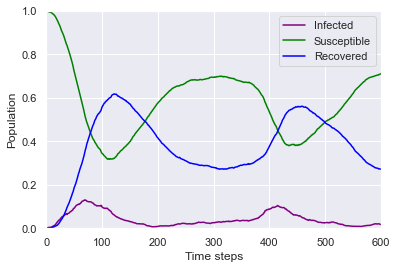

In [9]:
def virus_lineplot(data, ax):
    x = data.index.get_level_values('t')
    y = [data[var] for var in ['I', 'S', 'R']]
    
    ax.plot(x,y[0], 'purple', label = "Infected")
    ax.plot(x,y[1], 'green', label = "Susceptible")
    ax.plot(x,y[2], 'blue', label = "Recovered")
    
    ax.legend()
    ax.set_xlim(0, max(1, len(x)-1))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Population")
    

model = InfectionModel(parameters)
results = model.run()
fig, ax = plt.subplots()
virus_lineplot(results.variables.InfectionModel, ax)

Completed: 600 steps
Run time: 0:00:06.998717
Simulation finished


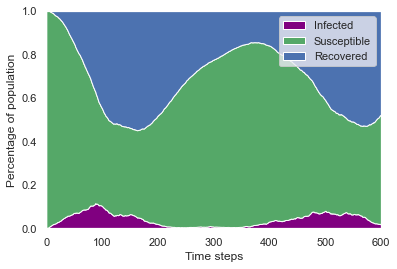

In [10]:
def virus_stackplot(data, ax):
    """ Stackplot of people's condition over time. """
    x = data.index.get_level_values('t')
    y = [data[var] for var in ['I', 'S', 'R']]

    sns.set()
    ax.stackplot(x, y, labels=['Infected', 'Susceptible', 'Recovered'],
                 colors = ['purple', 'g', 'b'])

    ax.legend()
    ax.set_xlim(0, max(1, len(x)-1))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Percentage of population")

model = InfectionModel(parameters)
results = model.run()
fig, ax = plt.subplots()
virus_stackplot(results.variables.InfectionModel, ax)

In [13]:
# create a single-run animation

def animation_plot(model, axz):
    ax1, ax2, ax3 = axz
    attr_grid = model.city.attr_grid('condition')
    color_dict = {0:'#03c900', 1:'#f6ff00', 2:'#bd00bd', 3:'#0095ff', None:'#000000'}
    ap.gridplot(attr_grid, ax=ax1, color_dict=color_dict, convert=True)
    ax1.set_title(f"Simulation of a infection\n"
                 f"Time-step: {model.t} S: ["
                 f"{len(model.agents.select(model.agents.condition == 0))}] "
                 "I: ["
                 f"{len(model.agents.select(model.agents.condition == 1))+len(model.agents.select(model.agents.condition == 2))}] "
                 "R: ["
                 f"{len(model.agents.select(model.agents.condition == 3))}]"
                )
    
    virus_lineplot(model.output.variables.InfectionModel, ax2)
    
    virus_stackplot(model.output.variables.InfectionModel, ax3)
    

    
fig, axs = plt.subplots(1, 3, figsize=(20,6))
model = InfectionModel(parameters)
animation = ap.animate(model, fig, axs, animation_plot)


In [ ]:
# Not run for space reasons
IPython.display.HTML(animation.to_jshtml(fps=15))